In [ ]:
pip install mediapipe

2025-12-04 16:15:08.920081: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764864908.942728     124 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764864908.949354     124 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading 1620 files...


  0%|          | 0/1620 [00:00<?, ?it/s]

Loading 416 files...


  0%|          | 0/416 [00:00<?, ?it/s]

I0000 00:00:1764864982.489194     124 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764864982.489828     124 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Starting Training...
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/40
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduc

I0000 00:00:1764864989.247641     189 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1764864989.964231     190 cuda_dnn.cc:529] Loaded cuDNN version 90300


23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1781 - loss: 2.4421INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
25/25 ━

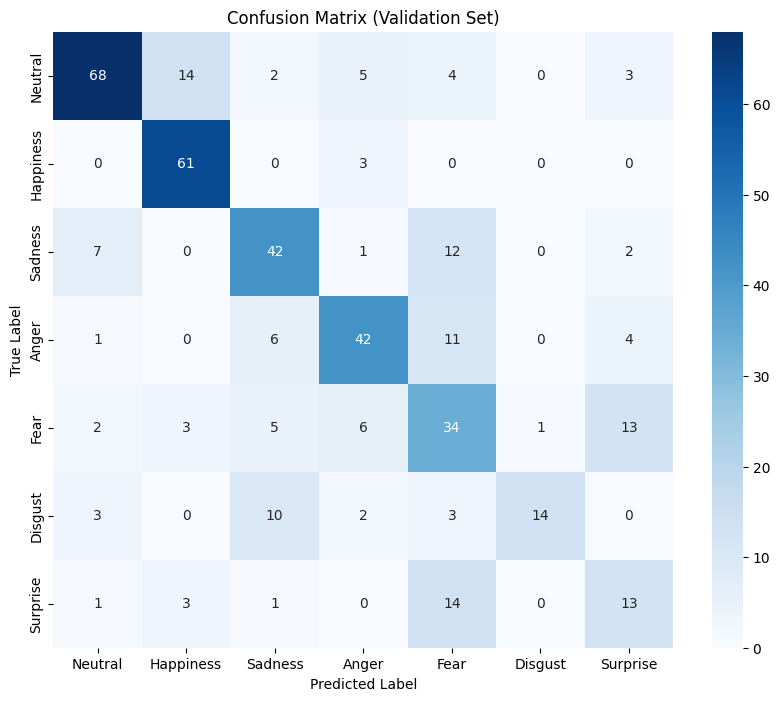

Inference model loaded.
Processing: TensorPix - clair_foy.mp4


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1764865048.837344    4258 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764865048.857831    4259 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764865048.863156    4259 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Processing: TensorPix - emilia_clark.mp4


W0000 00:00:1764865053.131050    4413 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764865053.153184    4412 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: TensorPix - sarah_gadon.mp4


W0000 00:00:1764865057.069088    4552 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764865057.091217    4553 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.



--- FINAL EMOTION TIMELINES ---


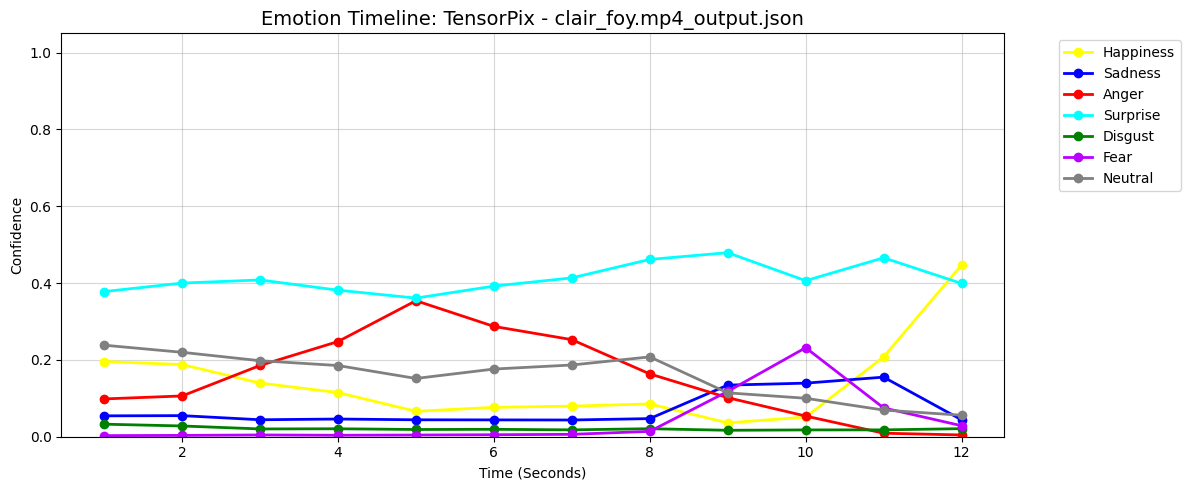

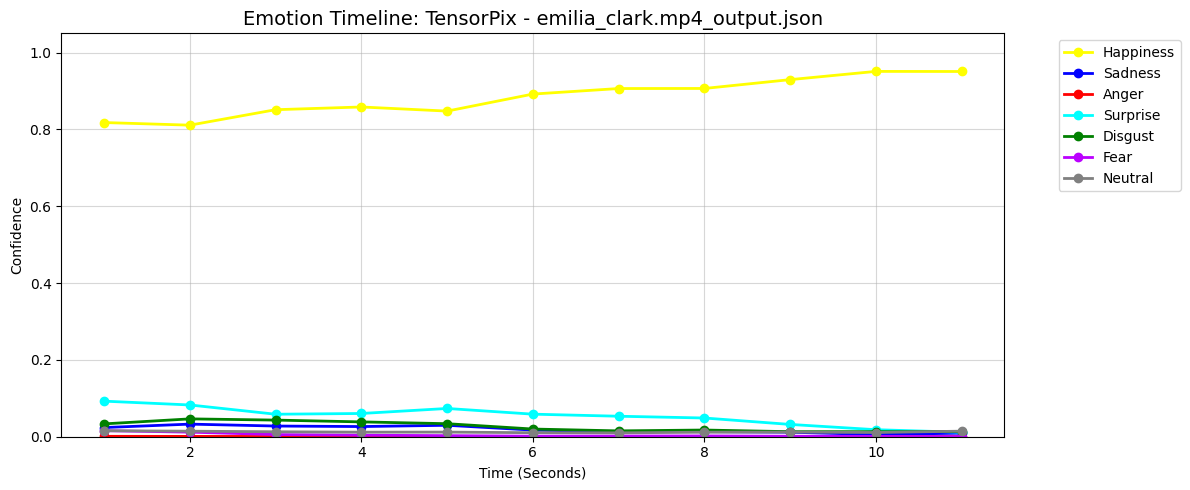

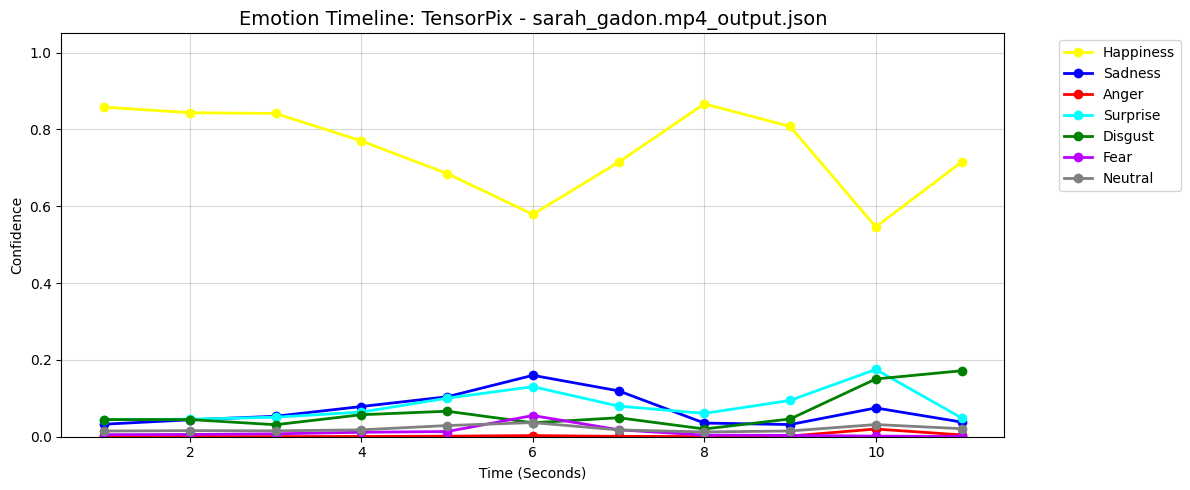

In [ ]:
# =================================================================
# EMOTION RECOGNITION (Noise Augmentation + Label Smoothing)
# =================================================================

import os
import glob
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.metrics import classification_report, confusion_matrix
import mediapipe as mp
from tqdm.notebook import tqdm

# --- CONFIGURATION ---
DATASET_PATH = "/kaggle/input/ravdess-facial-landmark-tracking"
TEST_VIDEOS_DIR = "/kaggle/input/test-emotion"
TEST_VIDEO_FILES = [
    "TensorPix - clair_foy.mp4",
    "TensorPix - emilia_clark.mp4",
    "TensorPix - sarah_gadon.mp4"
]

# 7 Classes (Merged Calm [02] -> Neutral [01])
EMOTION_MAP = {
    '01': 'Neutral', '02': 'Neutral', 
    '03': 'Happiness', '04': 'Sadness',
    '05': 'Anger', '06': 'Fear',
    '07': 'Disgust', '08': 'Surprise'
}
CLASSES = ["Neutral", "Happiness", "Sadness", "Anger", "Fear", "Disgust", "Surprise"]
class_to_idx = {c: i for i, c in enumerate(CLASSES)}

# Visualization Colors
EMOTION_COLORS = {
    "Happiness": "#FFFF00", "Sadness": "#0000FF", "Anger": "#FF0000",
    "Surprise": "#00FFFF", "Disgust": "#008000", "Fear": "#BB00FF",
    "Neutral": "#808080"
}

SEQ_LEN = 90 # 3 seconds context
INPUT_DIM = 136 # 68 landmarks * 2 (x,y)
BATCH_SIZE = 64
EPOCHS = 40

# ==========================================
# 1. DATA PROCESSING
# ==========================================

def normalize_landmarks(landmarks):
    """Centers and scales landmarks to be invariant to camera distance."""
    centroid = np.mean(landmarks, axis=0)
    centered = landmarks - centroid
    width = np.max(centered[:, 0]) - np.min(centered[:, 0])
    height = np.max(centered[:, 1]) - np.min(centered[:, 1])
    scale = max(width, height) + 1e-6
    return centered / scale

def load_data_from_csv(csv_paths):
    X, y = [], []
    x_cols = [f'x_{i}' for i in range(68)]
    y_cols = [f'y_{i}' for i in range(68)]
    
    print(f"Loading {len(csv_paths)} files...")
    for path in tqdm(csv_paths):
        filename = os.path.basename(path)
        parts = filename.split('-')
        if len(parts) < 3: continue
        
        emo_code = parts[2]
        if emo_code not in EMOTION_MAP: continue
        label = class_to_idx[EMOTION_MAP[emo_code]]
        
        try:
            df = pd.read_csv(path)
            if len(df) < 10: continue
            
            xs = df[x_cols].values
            ys = df[y_cols].values
            landmarks = np.stack([xs, ys], axis=-1)
            
            # Normalize sequence
            norm_seq = np.array([normalize_landmarks(lmk).flatten() for lmk in landmarks])
            
            # Pad or Crop to SEQ_LEN
            if len(norm_seq) >= SEQ_LEN:
                start = (len(norm_seq) - SEQ_LEN) // 2
                final_seq = norm_seq[start : start + SEQ_LEN]
            else:
                padding = np.zeros((SEQ_LEN - len(norm_seq), INPUT_DIM))
                final_seq = np.vstack([norm_seq, padding])
                
            X.append(final_seq)
            y.append(label)
        except Exception:
            continue
    return np.array(X, dtype='float32'), np.array(y, dtype='int32')

def get_splits(root_dir):
    all_files = glob.glob(os.path.join(root_dir, "*.csv"))
    # Logic: Test(1-4), Val(5-8), Train(9-24)
    test_actors = ['01', '02', '03', '04']
    val_actors = ['05', '06', '07', '08']
    train_actors = [f"{i:02d}" for i in range(9, 25)]
    
    train, val, test = [], [], []
    for f in all_files:
        # Filename format: 01-01-01-01-01-01-01.csv -> Actor is index 6
        actor = os.path.basename(f).split('-')[6].split('.')[0]
        if actor in test_actors: test.append(f)
        elif actor in val_actors: val.append(f)
        elif actor in train_actors: train.append(f)
    return train, val, test

# data load
train_files, val_files, test_files = get_splits(DATASET_PATH)
X_train, y_train = load_data_from_csv(train_files)
X_val, y_val = load_data_from_csv(val_files)

# we keep noise to prevent "Anger" memorization, but lower stddev to avoid "Happy" confusion
def augment(x, y):
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=0.01, dtype=tf.float32)
    return x + noise, y

# datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = (train_ds
            .shuffle(2000)
            .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE, drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE))

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

# ==========================================
# 2. MODEL TRAINING
# ==========================================

tf.keras.backend.clear_session()
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = keras.Sequential([
        layers.Input(shape=(SEQ_LEN, INPUT_DIM)),
        
        # 1D CNN for Micro-Expressions
        layers.Conv1D(64, 3, padding='same', kernel_regularizer=regularizers.l2(0.0005)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling1D(2),
        layers.Dropout(0.25),
        
        layers.Conv1D(128, 3, padding='same', kernel_regularizer=regularizers.l2(0.0005)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling1D(2),
        layers.Dropout(0.25),
        
        # LSTM for temporal dynamics
        layers.Bidirectional(layers.LSTM(128, return_sequences=False, kernel_regularizer=regularizers.l2(0.0005))),
        layers.Dropout(0.4),
        
        # classifier
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
        layers.Dense(len(CLASSES), activation='softmax')
    ])
    
    # Label Smoothing=0.1 helps the model accept "ambiguity" (common in real life)
    # instead of forcing a 100% "Anger" or 100% "Happy" decision.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
        metrics=['accuracy']
    )

# callbacks
checkpoint = keras.callbacks.ModelCheckpoint('model.weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss')
early_stop = keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor='val_loss')

print("Starting Training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop]
    # NOTE: REMOVED class_weight to restore natural balance
)

# ==========================================
# 3. METRICS & EVALUATION
# ==========================================
print("\n--- VALIDATION METRICS ---")
y_pred_probs = model.predict(X_val, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# report
print(classification_report(y_val, y_pred, target_names=CLASSES))

# confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix (Validation Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ==========================================
# 4. INFERENCE
# ==========================================

# single-device model
inference_model = keras.Sequential([
        layers.Input(shape=(SEQ_LEN, INPUT_DIM)),
        layers.Conv1D(64, 3, padding='same', kernel_regularizer=regularizers.l2(0.0005)),
        layers.BatchNormalization(), layers.Activation('relu'), layers.MaxPooling1D(2), layers.Dropout(0.25),
        layers.Conv1D(128, 3, padding='same', kernel_regularizer=regularizers.l2(0.0005)),
        layers.BatchNormalization(), layers.Activation('relu'), layers.MaxPooling1D(2), layers.Dropout(0.25),
        layers.Bidirectional(layers.LSTM(128, return_sequences=False, kernel_regularizer=regularizers.l2(0.0005))),
        layers.Dropout(0.4),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
        layers.Dense(len(CLASSES), activation='softmax')
])
inference_model.load_weights("model.weights.h5")
print("Inference model loaded.")

mp_face_mesh = mp.solutions.face_mesh
MP_TO_68 = [162,234,93,58,172,136,149,148,152,377,378,365,397,288,323,454,389,71,63,105,66,107,336,296,334,293,300,168,6,195,4,98,97,2,326,327,33,160,158,133,153,144,362,385,387,263,373,380,61,40,37,0,267,270,291,321,314,17,84,181,78,95,88,178,87,14,317,402]

def process_video_final(video_path):
    filename = os.path.basename(video_path)
    print(f"Processing: {filename}")
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 30
    
    results = {}
    buffer = []
    
    with mp_face_mesh.FaceMesh(max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5) as face_mesh:
        frame_idx = 0
        sec_counter = 1
        
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret: break
            
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            res = face_mesh.process(rgb)
            lmk_vec = np.zeros(INPUT_DIM)
            
            if res.multi_face_landmarks:
                raw = np.array([[res.multi_face_landmarks[0].landmark[i].x, res.multi_face_landmarks[0].landmark[i].y] for i in MP_TO_68])
                lmk_vec = normalize_landmarks(raw).flatten()
            
            # PADDING: Fill buffer on first frame
            if len(buffer) == 0:
                for _ in range(SEQ_LEN - 1): buffer.append(lmk_vec)
                
            buffer.append(lmk_vec)
            
            # Predict every 1 second
            if frame_idx > 0 and frame_idx % int(fps) == 0:
                input_seq = np.expand_dims(np.array(buffer[-SEQ_LEN:]), axis=0)
                preds = inference_model.predict(input_seq, verbose=0)[0]
                
                results[str(sec_counter)] = {
                    "happiness": float(preds[1]), "sadness": float(preds[2]),
                    "anger": float(preds[3]), "surprise": float(preds[6]),
                    "disgust": float(preds[5]), "fear": float(preds[4]),
                    "neutral": float(preds[0])
                }
                sec_counter += 1
            frame_idx += 1
            
    cap.release()
    out_path = f"{filename}_output.json"
    with open(out_path, 'w') as f:
        json.dump({"data": results}, f, indent=4)
    return out_path

# Run Inference
output_files = []
for vid in TEST_VIDEO_FILES:
    full_path = os.path.join(TEST_VIDEOS_DIR, vid)
    if os.path.exists(full_path):
        out_f = process_video_final(full_path)
        output_files.append(out_f)

# ==========================================
# 5. FINAL VISUALIZATION
# ==========================================
print("\n--- FINAL EMOTION TIMELINES ---")

def plot_timeline(json_file):
    with open(json_file, 'r') as f: data = json.load(f)['data']
    df = pd.DataFrame.from_dict(data, orient='index')
    df.index = df.index.astype(int)
    df = df.sort_index()
    
    plt.figure(figsize=(12, 5))
    for emotion, color in EMOTION_COLORS.items():
        if emotion.lower() in df.columns:
            plt.plot(df.index, df[emotion.lower()], marker='o', label=emotion, color=color, linewidth=2)
            
    plt.title(f'Emotion Timeline: {json_file}', fontsize=14)
    plt.xlabel('Time (Seconds)')
    plt.ylabel('Confidence')
    plt.ylim(0, 1.05)
    plt.grid(True, alpha=0.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

for f in output_files:
    plot_timeline(f)